In [1]:
!pip install -q langchain langgraph transformers torch accelerate matplotlib plotly

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda")

/home/jungi.byun/AMA/solution/jupyter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-07 09:04:56.515277: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 09:04:56.539455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751846696.566490  841081 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751846696.575123  841081 cuda_bl

In [3]:
from typing import TypedDict, Optional, Dict, Any
from langgraph.graph import StateGraph, END

class GeometryState(TypedDict):
    user_request: str
    math_concept: str = ""
    generated_code: str = ""

In [4]:
import json

def extract_shape_node(state: GeometryState) -> GeometryState:
    messages = [
        {
            "role": "system",
            "content": """
                사용자가 제공하는 수학과 관련된 문장에서 어떠한 개념을 그려주면 사용자의 이해를 도울 수 있을지, JSON 형식으로 출력하세요.
                아래 JSON의 schema에 맞게 하나만 출력하세요. 다른 설명은 절대 추가하지 마세요.
                쉼표, 따옴표, 중괄호 등 문법을 엄격히 지키세요. 문제가 있어도 반드시 완전한 JSON으로만 출력하세요.
                출력 형식 예시 (값은 사용자가 제공하는 수학과 관련된 문장에서 나온 개념을 사용해야 합니다):
                {
                    "math_concept": "원"
                }
                그릴 수 있는 개념은 다음과 같습니다. (사용자가 제공하는 수학과 관련된 문장에서 찾은 개념의 영단어와 문장을 영어로 번역한 것과 비교하여 찾아보세요)
                    - 원(Circle)
                    - 각 또는 각도(Angle)
                    - 직각(Right Angle)
                    - 직사각형(Rectangle)
                    - 직각삼각형(Right Triangle)
             """
        },
        {
            "role": "user",
            "content": state["user_request"]
        }
    ]
    
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    )

    output = model.generate(
        input_ids.to("cuda"),
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=128,
        do_sample=False,
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # 마크다운 제거 로직
    decoded = decoded[decoded.find("```json") + len("```json"):decoded.rfind("```")]
    parsed = json.loads(decoded)

    state["math_concept"] = parsed["math_concept"]

    return state

In [5]:
GEN_CIRCLE = """
import matplotlib.pyplot as plt
from io import StringIO

fig, ax = plt.subplots()
circle = plt.Circle((0, 0), radius=1, fill=False)
ax.add_patch(circle)
plt.plot(0,0,'o', markersize=2, color='k') 
ax.set_aspect('equal')
ax.set_xlim(0 - 1.5, 0 + 1.5)
ax.set_ylim(0 - 1.5, 0 + 1.5)

plt.title('Circle with radius 1 at (0, 0)')
plt.axis("off")
plt.show()
"""

In [6]:
GEN_RECTANGLE = """
import matplotlib.pyplot as plt

width = 2
height = 1

fig, ax = plt.subplots()
left = plt.plot([0, 0], [0, height], color='k')
right = plt.plot([width, width], [0, height], color='k')
bottom = plt.plot([0, width],[0, 0], color='k')
top = plt.plot([0, width], [height, height], color='k')
ax.set_aspect('equal')

plt.title('Rectangle with width 2, height 1')
plt.axis("off")
plt.show()
"""

In [7]:
GEN_ANGLE = """
import numpy as np
import matplotlib.pyplot as plt
import math

fig, ax = plt.subplots(2, 1)

# acuse angle
x_acuse = 1
theta_acuse = math.pi / 6
thetas_acuse = np.linspace(0, theta_acuse, 30)
slope_acuse = math.tan(theta_acuse)

ax[0].plot([0, x_acuse], [0, 0], color='k')
ax[0].plot([0, x_acuse], [0, slope_acuse], color='k')
ax[0].plot(0.2 * np.cos(thetas_acuse), 0.2* np.sin(thetas_acuse), color='k')

ax[0].set_aspect('equal')

ax[0].set_title('Angle 30°')
ax[0].axis("off")

# obtuse angle
x_obtuse = 1
theta_obtuse = math.pi * 2 / 3
thetas_obtuse = np.linspace(0, theta_obtuse, 30)
slope_obtuse = math.tan(theta_obtuse)

ax[1].plot([-0.5 * x_obtuse, 0], [-0.5 * slope_obtuse, 0], color='k')
ax[1].plot([0, x_obtuse], [0, 0], color='k')
ax[1].plot(0.2 * np.cos(thetas_obtuse), 0.2* np.sin(thetas_obtuse), color='k')

ax[1].set_aspect('equal')

ax[1].set_title('Angle 120°')
ax[1].axis("off")

plt.tight_layout()
plt.show()
"""

In [8]:
GEN_PERP = """
import matplotlib.pyplot as plt

l = 0.2

fig, ax = plt.subplots()
plt.axvline(x=0, linewidth=3, color='k')
plt.axhline(y=0, linewidth=3, color='k')
plt.plot([l, l], [0, l], color='k')
plt.plot([0, l], [l, l], color='k')

plt.xlim(0, l + 1)
plt.ylim(0, l + 1)

ax.set_aspect('equal')

plt.title('Angle 90°')
plt.axis("off")
plt.show()
"""

In [9]:
GEN_RIGHT_TRIANGLE = """
import matplotlib.pyplot as plt

x = 4
y = 3
epsilon = 0.1 * min(x, y)

fig, ax = plt.subplots()
plt.plot([0, x], [0, 0], color='k')
plt.plot([x, x], [0, y], color='k')
plt.plot([0, x], [0, y], color='k')

plt.plot([x - epsilon, x - epsilon], [0, epsilon], color='k')
plt.plot([x - epsilon, x], [epsilon, epsilon], color='k')

ax.set_aspect('equal')

plt.title('Right Triangle')
plt.axis("off")
plt.show()
"""

In [10]:
def generate_code_node(state: GeometryState) -> GeometryState:
    concept = state["math_concept"]

    if concept == "원" or concept == "Circle":
        code = GEN_CIRCLE
    elif concept == "직사각형" or concept == "Rectangle" :
        code = GEN_RECTANGLE
    elif concept == "각" or concept == "각도" or concept == "Angle":
        code = GEN_ANGLE
    elif concept == "직각" or concept == "Right Angle":
        code = GEN_PERP
    elif concept == "직각삼각형" or concept == "Right Triangle":
        code = GEN_RIGHT_TRIANGLE
    else:
        code = f"# '{concept}'을 그리는 코드는 아직 구현되지 않았습니다."

    return {**state, "generated_code": code}

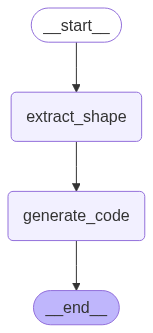

In [11]:
# LangGraph StateGraph 생성
geometry_agent = StateGraph(GeometryState)

# 노드 등록
geometry_agent.add_node("extract_shape", extract_shape_node)
geometry_agent.add_node("generate_code", generate_code_node)

# 엣지 연결
geometry_agent.set_entry_point("extract_shape")
geometry_agent.add_edge("extract_shape", "generate_code")
geometry_agent.add_edge("generate_code", END)

# 그래프 완성
app = geometry_agent.compile()
app

요청한 문장: 중심이 (0,0)이고 반지름이 2인 원을 그려주세요.
추출된 개념: 원

생성된 코드:
 
import matplotlib.pyplot as plt
from io import StringIO

fig, ax = plt.subplots()
circle = plt.Circle((0, 0), radius=1, fill=False)
ax.add_patch(circle)
plt.plot(0,0,'o', markersize=2, color='k') 
ax.set_aspect('equal')
ax.set_xlim(0 - 1.5, 0 + 1.5)
ax.set_ylim(0 - 1.5, 0 + 1.5)

plt.title('Circle with radius 1 at (0, 0)')
plt.axis("off")
plt.show()



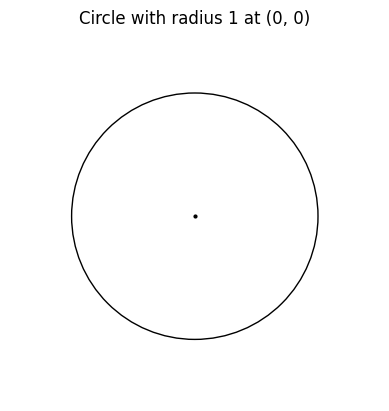

요청한 문장: 직사각형의 넓이
추출된 개념: Rectangle

생성된 코드:
 
import matplotlib.pyplot as plt

width = 2
height = 1

fig, ax = plt.subplots()
left = plt.plot([0, 0], [0, height], color='k')
right = plt.plot([width, width], [0, height], color='k')
bottom = plt.plot([0, width],[0, 0], color='k')
top = plt.plot([0, width], [height, height], color='k')
ax.set_aspect('equal')

plt.title('Rectangle with width 2, height 1')
plt.axis("off")
plt.show()



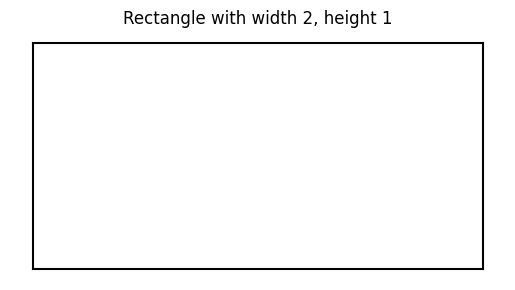

요청한 문장: 임의의 각도를 그려줘
추출된 개념: 각도

생성된 코드:
 
import numpy as np
import matplotlib.pyplot as plt
import math

fig, ax = plt.subplots(2, 1)

# acuse angle
x_acuse = 1
theta_acuse = math.pi / 6
thetas_acuse = np.linspace(0, theta_acuse, 30)
slope_acuse = math.tan(theta_acuse)

ax[0].plot([0, x_acuse], [0, 0], color='k')
ax[0].plot([0, x_acuse], [0, slope_acuse], color='k')
ax[0].plot(0.2 * np.cos(thetas_acuse), 0.2* np.sin(thetas_acuse), color='k')

ax[0].set_aspect('equal')

ax[0].set_title('Angle 30°')
ax[0].axis("off")

# obtuse angle
x_obtuse = 1
theta_obtuse = math.pi * 2 / 3
thetas_obtuse = np.linspace(0, theta_obtuse, 30)
slope_obtuse = math.tan(theta_obtuse)

ax[1].plot([-0.5 * x_obtuse, 0], [-0.5 * slope_obtuse, 0], color='k')
ax[1].plot([0, x_obtuse], [0, 0], color='k')
ax[1].plot(0.2 * np.cos(thetas_obtuse), 0.2* np.sin(thetas_obtuse), color='k')

ax[1].set_aspect('equal')

ax[1].set_title('Angle 120°')
ax[1].axis("off")

plt.tight_layout()
plt.show()



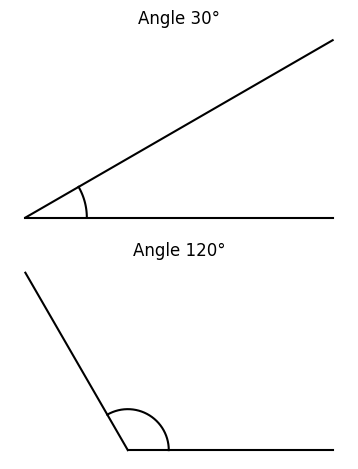

요청한 문장: 직각을 표현해줘
추출된 개념: 직각

생성된 코드:
 
import matplotlib.pyplot as plt

l = 0.2

fig, ax = plt.subplots()
plt.axvline(x=0, linewidth=3, color='k')
plt.axhline(y=0, linewidth=3, color='k')
plt.plot([l, l], [0, l], color='k')
plt.plot([0, l], [l, l], color='k')

plt.xlim(0, l + 1)
plt.ylim(0, l + 1)

ax.set_aspect('equal')

plt.title('Angle 90°')
plt.axis("off")
plt.show()



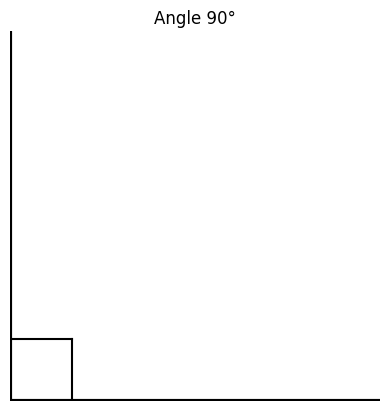

요청한 문장: 피타고라스 정리를 위해 직각삼각형 하나를 그려줘
추출된 개념: 직각삼각형

생성된 코드:
 
import matplotlib.pyplot as plt

x = 4
y = 3
epsilon = 0.1 * min(x, y)

fig, ax = plt.subplots()
plt.plot([0, x], [0, 0], color='k')
plt.plot([x, x], [0, y], color='k')
plt.plot([0, x], [0, y], color='k')

plt.plot([x - epsilon, x - epsilon], [0, epsilon], color='k')
plt.plot([x - epsilon, x], [epsilon, epsilon], color='k')

ax.set_aspect('equal')

plt.title('Right Triangle')
plt.axis("off")
plt.show()



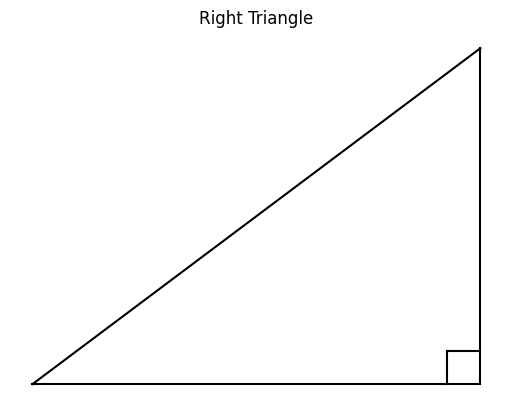

In [12]:
# 사용자 입력
# user_input = "중심이 (0,0)이고 반지름이 2인 원을 그려주세요."
# user_input = "직사각형의 넓이"
# user_input = "임의의 각도를 그려줘"
# user_input = "직각을 표현해줘"
user_input = "피타고라스 정리를 위해 직각삼각형 하나를 그려줘"

import plotly.io as pio
pio.renderers.default = "notebook"

input_samples = [
    "중심이 (0,0)이고 반지름이 2인 원을 그려주세요.",
    "직사각형의 넓이",
    "임의의 각도를 그려줘",
    "직각을 표현해줘",
    "피타고라스 정리를 위해 직각삼각형 하나를 그려줘",
]

# 그래프 호출
for user_input in input_samples:
    result = app.invoke({"user_request": user_input})

    # 결과 출력
    print("요청한 문장:", result["user_request"])
    print("추출된 개념:", result["math_concept"])
    print("\n생성된 코드:\n", result["generated_code"])
    exec(result["generated_code"])
    print("=" * 50)